In [23]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.ops import nearest_points
from shapely.geometry import Point
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
import random
import string
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial import Voronoi

In [24]:
ORIGIN_FILE = '../origin_data/bigger_survey_results.csv'
DESTINATION_FILE = '../ano_data/anonymized_bigger_survey_data.csv'
SIZE_FIGURE = (20, 10)

SECRET_KEYS = [''.join(random.choices(string.ascii_letters + string.digits, k=5)) for _ in range(3)]

ROUND_INTERVAL_TIME = '10min'
SHIFT_RANGE_TIME = 30

# Privacy and Utility Constants
GRID_SIZE = 0.01              # Grid size for seed generation (only for grid-based sampling)
# Increase GRID_SIZE to improve privacy (larger cells, less precision).
# Decrease GRID_SIZE to improve utility (smaller cells, more detail).

DBSCAN_EPS = 0.08             # Maximum distance for DBSCAN clustering (only for DBSCAN sampling)
# Increase DBSCAN_EPS to improve privacy (fewer, larger clusters).
# Decrease DBSCAN_EPS to improve utility (more, smaller clusters).

DBSCAN_MIN_SAMPLES = 20       # Minimum samples for DBSCAN clustering (only for DBSCAN sampling)
# Increase DBSCAN_MIN_SAMPLES to improve privacy (larger clusters, higher threshold).
# Decrease DBSCAN_MIN_SAMPLES to improve utility (smaller clusters, lower threshold).

MAX_RADIUS = 0.04            # Maximum distance for anonymized points
# Increase MAX_RADIUS to improve privacy (allows points to deviate more, reducing risk of re-identification).
# Decrease MAX_RADIUS to improve utility (keeps points closer to their centroids).

PRIVACY_BUDGET = 1.5          # Epsilon for differential privacy
# Increase PRIVACY_BUDGET to improve utility (less noise, more precise anonymization).
# Decrease PRIVACY_BUDGET to improve privacy (more noise, stronger anonymization).


SENSITIVITY = 1.0             # Sensitivity of the geographic data (fixed to 1.0)
# Adjust SENSITIVITY only if the maximum geographic change in the dataset needs to be accounted for.
# Larger SENSITIVITY indirectly reduces utility by scaling up noise, but increases privacy guarantees.


In [25]:
columns_name = ['id', 'date', 'latitude', 'longitude']
original_data = pd.read_csv(ORIGIN_FILE, names=columns_name, sep='\t')
original_data['date'] = pd.to_datetime(original_data['date'])
original_data['week'] = original_data['date'].dt.isocalendar().week

In [26]:
# def plot_user_entries(data, id_column='id', date_column='date'):
#     """
#     Plots the number of entries for each user ID over time.
#     Parameters:
#         data (pd.DataFrame): Input dataset.
#         id_column (str): Column containing user IDs.
#         date_column (str): Column containing datetime values.
#     """
#     user_entries = data.groupby(id_column)[date_column].count().sort_values(ascending=False)
    
#     plt.figure(figsize=SIZE_FIGURE)
#     user_entries.plot(kind='bar')
#     plt.title('Number of Entries for Each User ID')
#     plt.xlabel('User ID')
#     plt.ylabel('Number of Entries')
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.xticks(rotation=90)
#     plt.show()

# # Example usage
# plot_user_entries(original_data)

In [27]:
# # Group by 'id' and 'week' and count the number of entries
# user_weekly_entries = original_data.groupby(['id', 'week']).size().reset_index(name='entries')

# # Display the result
# print(user_weekly_entries)
# plt.figure(figsize=SIZE_FIGURE)
# sns.barplot(x='week', y='entries', hue='id', data=user_weekly_entries, dodge=True)
# plt.title('Weekly Entries per User')
# plt.xlabel('Week')
# plt.ylabel('Number of Entries')
# plt.legend(title='User ID')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

In [28]:
def spatial_analysis(data):
    """
    Analyzes and visualizes spatial patterns in the dataset.
    Parameters:
        data (pd.DataFrame): DataFrame with 'latitude' and 'longitude' columns.
    """
    # Convert to GeoDataFrame
    geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]
    gdf = gpd.GeoDataFrame(data, geometry=geometry)

    # Plot spatial density
    plt.figure(figsize=SIZE_FIGURE)
    plt.scatter(data['longitude'], data['latitude'], alpha=0.5, s=10)
    plt.title('Spatial Distribution of Data')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(alpha=0.5)
    plt.show()

    # Heatmap of spatial density (using seaborn)
    plt.figure(figsize=SIZE_FIGURE)
    sns.kdeplot(x=data['longitude'], y=data['latitude'], cmap="viridis", fill=True)
    plt.title('Spatial Density Heatmap')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(alpha=0.5)
    plt.show()


In [29]:
def user_level_analysis(data):
    """
    Analyzes and visualizes user-level patterns in the dataset.
    Parameters:
        data (pd.DataFrame): DataFrame with 'id' column and other relevant attributes.
    """
    # Time-series pattern for a random sample of users
    sampled_users = data['id'].sample(5, random_state=42)
    sampled_data = data[data['id'].isin(sampled_users)]

    # Plot latitude over time for sampled users
    plt.figure(figsize=SIZE_FIGURE)  # Adjusted figure size
    for user_id in sampled_users:
        user_data = sampled_data[sampled_data['id'] == user_id]
        plt.plot(user_data['date'], user_data['latitude'], label=f'User {user_id}', alpha=0.7)

    plt.title('Time-Series Pattern for Sampled Users (Latitude)')
    plt.xlabel('Time')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(alpha=0.7)
    plt.show()

     # Plot longitude over time for sampled users
    plt.figure(figsize=SIZE_FIGURE)  # Adjusted figure size
    for user_id in sampled_users:
        user_data = sampled_data[sampled_data['id'] == user_id]
        plt.plot(user_data['date'], user_data['longitude'], label=f'User {user_id}', alpha=0.7)

    plt.title('Time-Series Pattern for Sampled Users (Longitude)')
    plt.xlabel('Time')
    plt.ylabel('Longitude')
    plt.legend()
    plt.grid(alpha=0.7)
    plt.show()


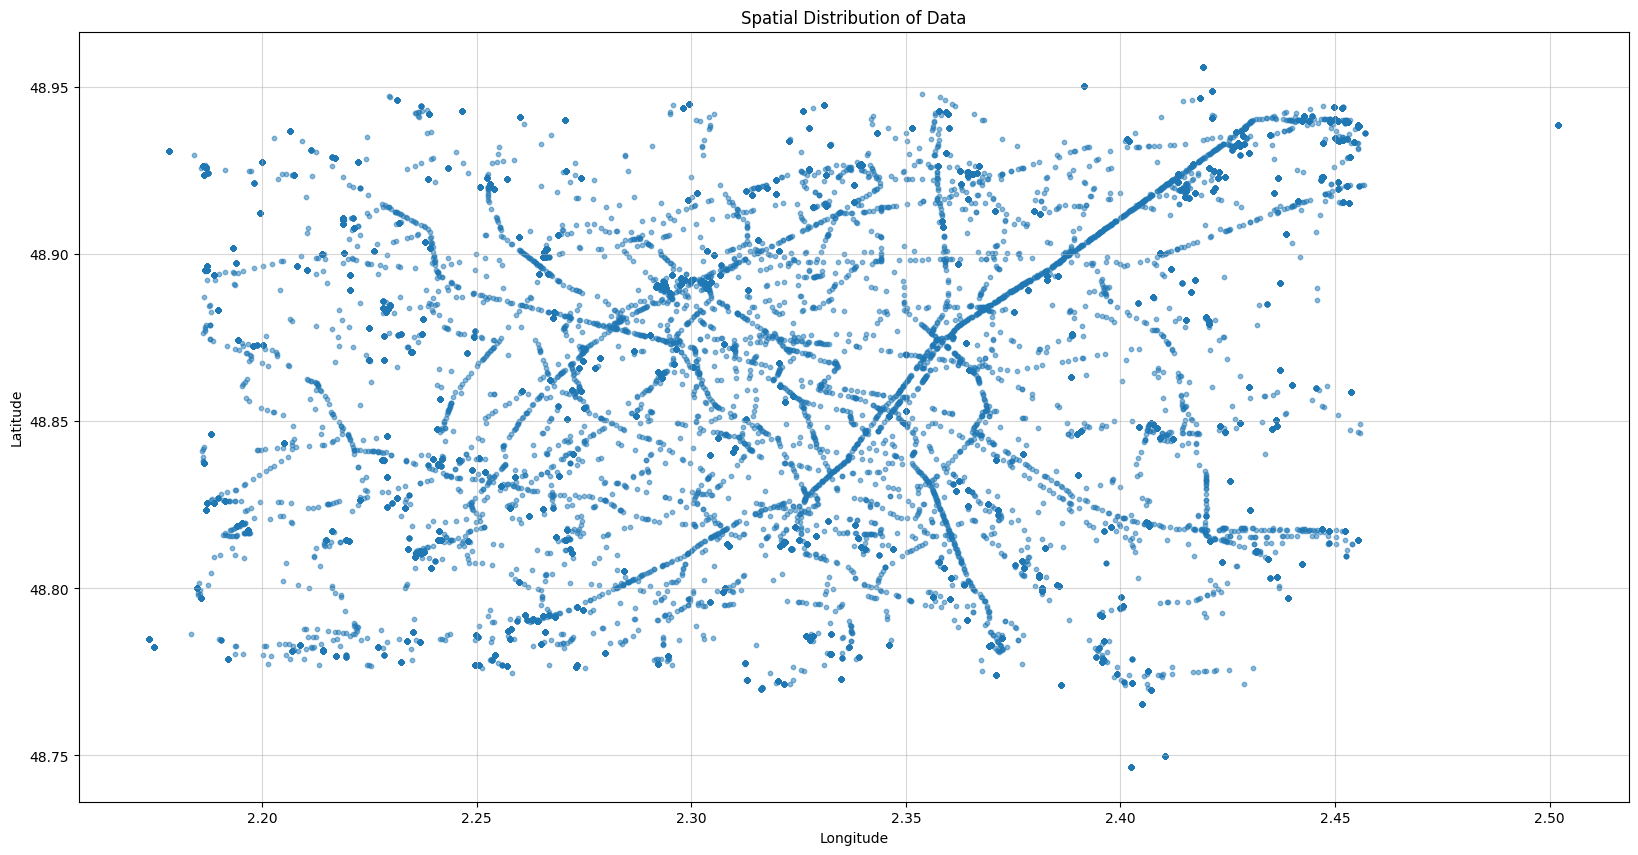

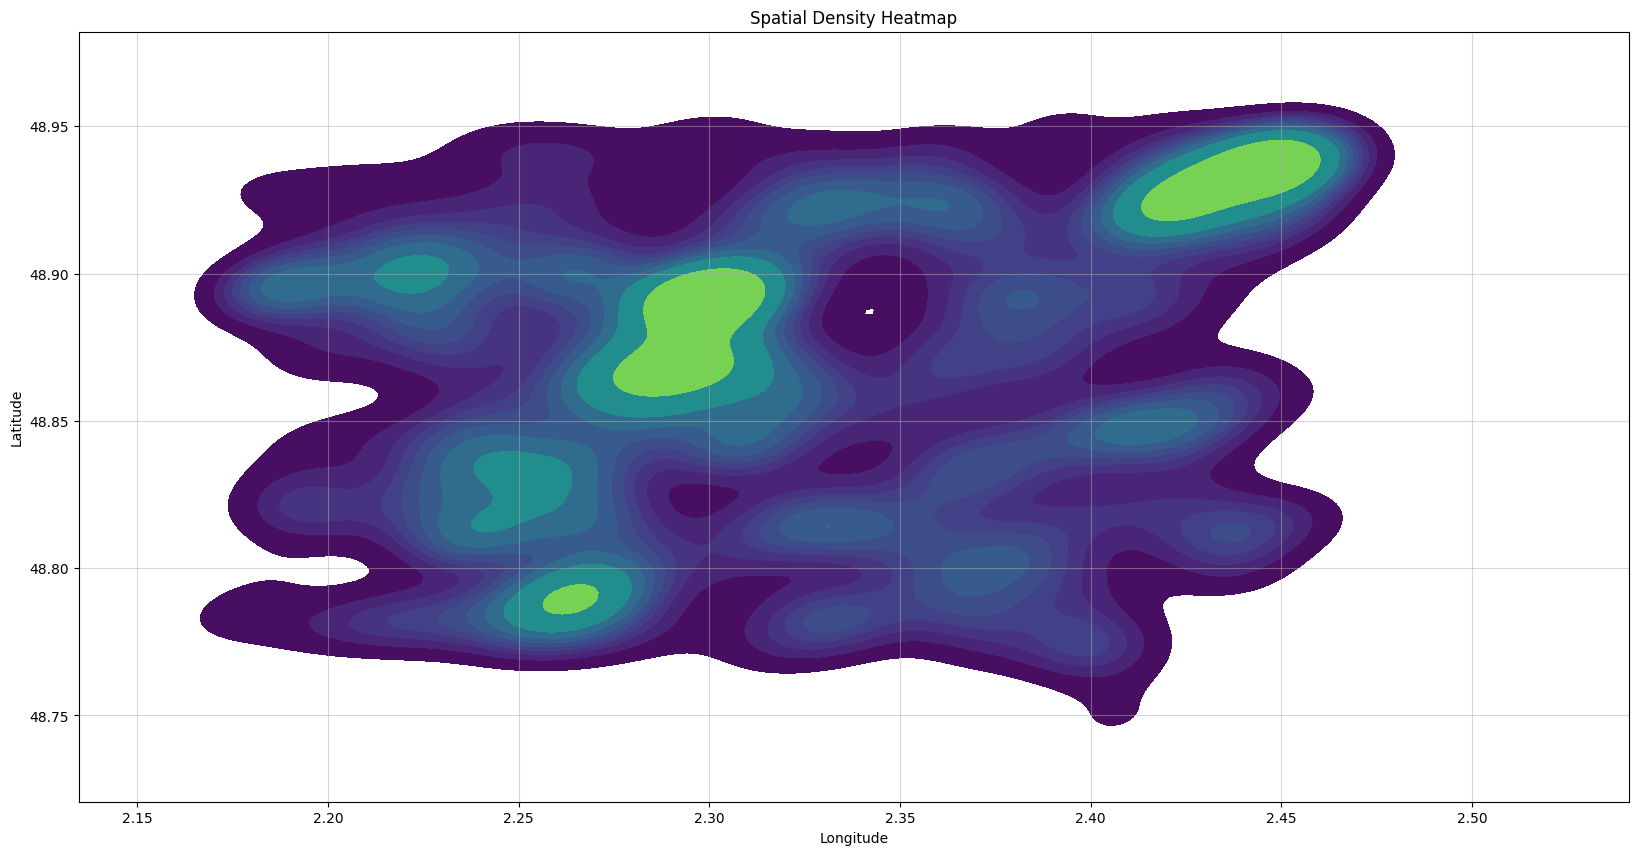

In [30]:
spatial_analysis(original_data)

In [31]:
def mask_id_with_secret(data, id_column='id', week_column='week', secret_keys=SECRET_KEYS):
    """
    Mask the ID column by concatenating the user ID and week with random secret keys and hashing.
    Parameters:
        data (pd.DataFrame): Input dataset.
        id_column (str): Column containing user IDs.
        week_column (str): Column containing ISO week.
        secret_keys (list): List of secret keys.
    Returns:
        pd.DataFrame: Dataset with masked IDs.
    """
    mapping = {}
    def generate_masked_id(user_id, week):
        key = (user_id, week)
        if key not in mapping:
            key1, key2, key3 = random.sample(secret_keys, 3)
            concatenated = f'{key1}{user_id}{key2}{week}{key3}'
            masked_id = hashlib.sha256(concatenated.encode()).hexdigest()[:8]
            mapping[key] = masked_id
        return mapping[key]
    data['masked_id'] = data.apply(lambda row: generate_masked_id(row[id_column], row[week_column]), axis=1)
    # return data

In [32]:
mask_id_with_secret(original_data)

In [33]:
def anonymize_time(data, id_column='id', time_column='date', round_interval=ROUND_INTERVAL_TIME, shift_range=SHIFT_RANGE_TIME):
    """
    Anonymize time data by first rounding to intervals and then applying a user-specific offset.
    Parameters:
        data (pd.DataFrame): Input dataset.
        id_column (str): Column containing user IDs.
        time_column (str): Column containing time values.
        round_interval (str): Interval for rounding.
        shift_range (int): Maximum shift range in minutes.
    Returns:
        pd.DataFrame: Dataset with anonymized time.
    """
    # Step 1: Round timestamps to the nearest interval
    data['anonymized_time'] = data[time_column].dt.floor(round_interval)

    # Step 2: Define a function to generate a consistent hash-based offset for each user
    def user_offset(user_id):
        # Hash the user ID and convert it to an integer
        hash_value = int(hashlib.sha256(str(user_id).encode()).hexdigest(), 16)
        # Map the hash to a range within [-shift_range, +shift_range]
        return (hash_value % (2 * shift_range)) - shift_range
    
    user_offsets = data[id_column].map(user_offset)

    # Step 3: Apply the offset and ensure it stays within the same day
    def apply_offset(row):
        original_time = row['anonymized_time']
        offset = pd.Timedelta(minutes=row['user_offset'])
        new_time = original_time + offset
        # Ensure the new time stays within the same day
        if new_time.day != original_time.day:
            if new_time < original_time:
                new_time = original_time.replace(hour=0, minute=0, second=0, microsecond=0)
            else:
                new_time = original_time.replace(hour=23, minute=59, second=59, microsecond=999999)
        return new_time

    data['user_offset'] = user_offsets
    data['anonymized_time'] = data.apply(apply_offset, axis=1)
    data.drop(columns=['user_offset'], inplace=True)
    # return data

In [34]:
anonymize_time(original_data)

In [35]:
# Focus on dense regions
def generate_seeds_dbscan(data, lat_column='latitude', lon_column='longitude', 
                          eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES, visualize=True):
    """
    Generate seeds using DBSCAN clustering.
    Parameters:
        data (pd.DataFrame): Input dataset.
        lat_column (str): Column name for latitude.
        lon_column (str): Column name for longitude.
        eps (float): Maximum distance between points to be considered a cluster.
        min_samples (int): Minimum number of points to form a cluster.
        visualize (bool): Whether to visualize the clusters.
    Returns:
        np.ndarray: Array of seed coordinates (latitude, longitude).
    """
    # Extract latitude and longitude as input for clustering
    coords = data[[lat_column, lon_column]].values
    
    # Normalize coordinates for clustering
    coords_scaled = StandardScaler().fit_transform(coords)
    
    # Set default parameters if not provided
    eps = eps or 0.01 * np.mean([data[lat_column].max() - data[lat_column].min(),
                                 data[lon_column].max() - data[lon_column].min()])
    min_samples = min_samples or max(5, int(0.01 * len(data)))
    
    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(coords_scaled)
    
    # Compute cluster centroids
    numeric_data = data[[lat_column, lon_column]].copy()
    numeric_data['cluster'] = labels  # Add cluster labels
    clusters = numeric_data[numeric_data['cluster'] != -1].groupby('cluster').mean()
    
    # Return an empty array if no clusters are formed
    if clusters.empty:
        return np.empty((0, 2))
    
    seeds = clusters[[lat_column, lon_column]].values  # Extract centroid coordinates as seeds
    
    # Optional: Visualize the clusters
    if visualize:
        plt.figure(figsize=(10, 6))
        plt.scatter(data[lon_column], data[lat_column], c=labels, cmap='viridis', s=10, alpha=0.6)
        plt.scatter(seeds[:, 1], seeds[:, 0], color='red', marker='x', s=100, label='Cluster Centroids')
        plt.title('DBSCAN Clustering and Seed Generation')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend()
        plt.grid(alpha=0.5)
        plt.show()
    
    return seeds

In [36]:

# When requiring uniform spatial coverage
def generate_seeds_grid(data, lat_column='latitude', lon_column='longitude', grid_size=GRID_SIZE, visualize=True):
    """
    Generate seeds using grid-based sampling and visualize them.
    Parameters:
        data (pd.DataFrame): Input dataset.
        lat_column (str): Column name for latitude.
        lon_column (str): Column name for longitude.
        grid_size (float): Size of the grid cells in latitude/longitude degrees.
        visualize (bool): Whether to visualize the grid points.
    Returns:
        np.ndarray: Array of seed coordinates (latitude, longitude).
    """
    # Get the bounding box of the dataset
    lat_min, lat_max = data[lat_column].min(), data[lat_column].max()
    lon_min, lon_max = data[lon_column].min(), data[lon_column].max()
    
    # Generate grid points
    lat_points = np.arange(lat_min, lat_max, grid_size)
    lon_points = np.arange(lon_min, lon_max, grid_size)
    seeds = np.array([[lat, lon] for lat in lat_points for lon in lon_points])
    
    # Optional: Visualize the grid points
    if visualize:
        plt.figure(figsize=(10, 6))
        plt.scatter(data[lon_column], data[lat_column], s=10, alpha=0.5, label='Original Data')
        plt.scatter(seeds[:, 1], seeds[:, 0], color='red', marker='x', label='Grid Seeds')
        plt.title(f'Grid-Based Seed Generation (Grid Size: {grid_size})')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend()
        plt.grid(alpha=0.5)
        plt.show()
    
    return seeds

In [37]:
from shapely import MultiPoint


def anonymize_data(data, lat_column='latitude', lon_column='longitude', max_radius=MAX_RADIUS, epsilon=PRIVACY_BUDGET, seedsGenerator=generate_seeds_grid):
    """
    Anonymize latitude and longitude
    Parameters:
        data (pd.DataFrame): Input dataset.
        lat_column (str): Column name for latitude.
        lon_column (str): Column name for longitude.
        max_radius (float): Maximum distance for Laplace noise.
        epsilon (float): Privacy budget for differential privacy.
    Returns:
        pd.DataFrame: Dataset with anonymized latitude and longitude.
    """
    # Step 1: Define Voronoi seeds (these can be predefined or clustered centroids)
    seeds = seedsGenerator(data)
    
    # Step 3: Map each point to the nearest Voronoi centroid
    def map_to_centroid(lat, lon):
        point = Point(lon, lat)
        centroids = [Point(seed[1], seed[0]) for seed in seeds]
        nearest_centroid = nearest_points(point, MultiPoint(centroids))[1]  # Get the nearest centroid
        return nearest_centroid.y, nearest_centroid.x

    data[['mapped_lat', 'mapped_lon']] = data.apply(
        lambda row: map_to_centroid(row[lat_column], row[lon_column]),
        axis=1, result_type='expand'
    )
    
    # Step 4: Add Differential Privacy using Laplace noise
    sensitivity = 1.0  # Sensitivity of the geographic data
    scale = sensitivity / epsilon

    def add_directional_noise(origin_lat, origin_lon, centroid_lat, centroid_lon):
        # Compute direction vector
        direction_vector = np.array([centroid_lat - origin_lat, centroid_lon - origin_lon])
        direction_magnitude = np.linalg.norm(direction_vector)
        
        # Normalize direction vector
        if direction_magnitude == 0:
            unit_vector = np.array([0, 0])  # Handle case where origin == centroid
        else:
            unit_vector = direction_vector / direction_magnitude

        # Generate noise scaled by Laplace distribution
        noise_distance = np.clip(np.random.laplace(0, scale), 0, max_radius)

        # Compute new anonymized point along the direction
        anonymized_lat = origin_lat + noise_distance * unit_vector[0]
        anonymized_lon = origin_lon + noise_distance * unit_vector[1]
        return anonymized_lat, anonymized_lon

    data[['anonymized_lat', 'anonymized_lon']] = data.apply(
        lambda row: add_directional_noise(
            row[lat_column], row[lon_column], row['mapped_lat'], row['mapped_lon']
        ),
        axis=1, result_type='expand'
    )
    
    return data

In [38]:
def anonymize_data_from_centroid(data, lat_column='latitude', lon_column='longitude', max_radius=MAX_RADIUS, epsilon=PRIVACY_BUDGET, seedsGenerator=generate_seeds_grid):
    """
    Anonymize latitude and longitude using Voronoi Tessellation and Differential Privacy, spreading noise from the Voronoi centroid.
    Parameters:
        data (pd.DataFrame): Input dataset.
        lat_column (str): Column name for latitude.
        lon_column (str): Column name for longitude.
        max_radius (float): Maximum distance for Laplace noise.
        epsilon (float): Privacy budget for differential privacy.
    Returns:
        pd.DataFrame: Dataset with anonymized latitude and longitude.
    """
    # Step 1: Define Voronoi seeds (these can be predefined or clustered centroids)
    seeds = seedsGenerator(data)
    # Step 2: Create Voronoi tessellation
    vor = Voronoi(seeds)
    
    # Step 3: Map each point to the nearest Voronoi centroid
    def map_to_voronoi_centroid(lat, lon):
        point = Point(lon, lat)
        centroids = [Point(seed[1], seed[0]) for seed in seeds]
        nearest_centroid = nearest_points(point, MultiPoint(centroids))[1]  # Get the nearest centroid
        return nearest_centroid.y, nearest_centroid.x

    data[['mapped_lat', 'mapped_lon']] = data.apply(
        lambda row: map_to_voronoi_centroid(row[lat_column], row[lon_column]),
        axis=1, result_type='expand'
    )
    
    # Step 4: Add Differential Privacy using Laplace noise
    sensitivity = 1.0  # Sensitivity of the geographic data
    scale = sensitivity / epsilon

    def add_noise_from_centroid(centroid_lat, centroid_lon):
        # Generate random direction
        angle = np.random.uniform(0, 2 * np.pi)  # Random angle in radians
        # Generate noise scaled by Laplace distribution
        noise_distance = np.clip(np.random.laplace(0, scale), 0, max_radius)

        # Compute new anonymized point based on centroid
        anonymized_lat = centroid_lat + noise_distance * np.cos(angle)
        anonymized_lon = centroid_lon + noise_distance * np.sin(angle)
        return anonymized_lat, anonymized_lon

    data[['anonymized_lat', 'anonymized_lon']] = data.apply(
        lambda row: add_noise_from_centroid(
            row['mapped_lat'], row['mapped_lon']
        ),
        axis=1, result_type='expand'
    )
    
    return data


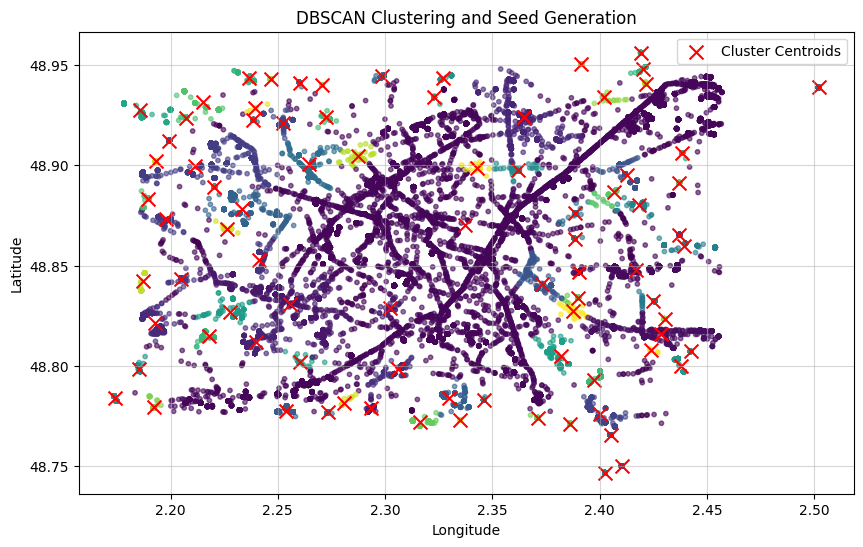

,id,date,latitude,longitude,week,masked_id,anonymized_time,mapped_lat,mapped_lon,anonymized_lat,anonymized_lon
0,2,2024-10-01 03:05:25,48.791948,2.266914,40,9d615bdc,2024-10-01 02:51:00,48.802082,2.260327,48.825485,2.245114
1,3,2024-10-01 10:48:32,48.847932,2.408468,40,51026368,2024-10-01 10:48:00,48.847873,2.417022,48.847657,2.448467
2,3,2024-10-01 09:55:43,48.847932,2.408468,40,51026368,2024-10-01 09:58:00,48.847873,2.417022,48.847657,2.448467
3,3,2024-10-01 19:10:00,48.845129,2.409336,40,51026368,2024-10-01 19:18:00,48.847873,2.417022,48.845129,2.409336
4,5,2024-10-01 01:59:54,48.811332,2.431745,40,d2fdf202,2024-10-01 01:33:00,48.815658,2.428413,48.843021,2.407336
...,...,...,...,...,...,...,...,...,...,...,...
45207,196,2025-01-15 20:45:55,48.919831,2.415036,3,a1110a66,2025-01-15 20:57:00,48.934021,2.402173,48.919831,2.415036
45208,197,2025-01-15 19:06:26,48.922690,2.369036,3,720c0511,2025-01-15 18:43:00,48.923892,2.364875,48.922690,2.369036
45209,197,2025-01-15 11:01:22,48.924742,2.364148,3,720c0511,2025-01-15 10:43:00,48.923892,2.364875,48.894347,2.390151
45210,199,2025-01-15 12:51:56,48.891520,2.303246,3,3fc7e0b4,2025-01-15 12:33:00,48.904568,2.287263,48.891520,2.303246


In [39]:
anonymize_data(original_data, seedsGenerator=generate_seeds_dbscan)

In [40]:
anonymized_data = original_data[['masked_id', 'anonymized_time', 'anonymized_lat', 'anonymized_lon']]

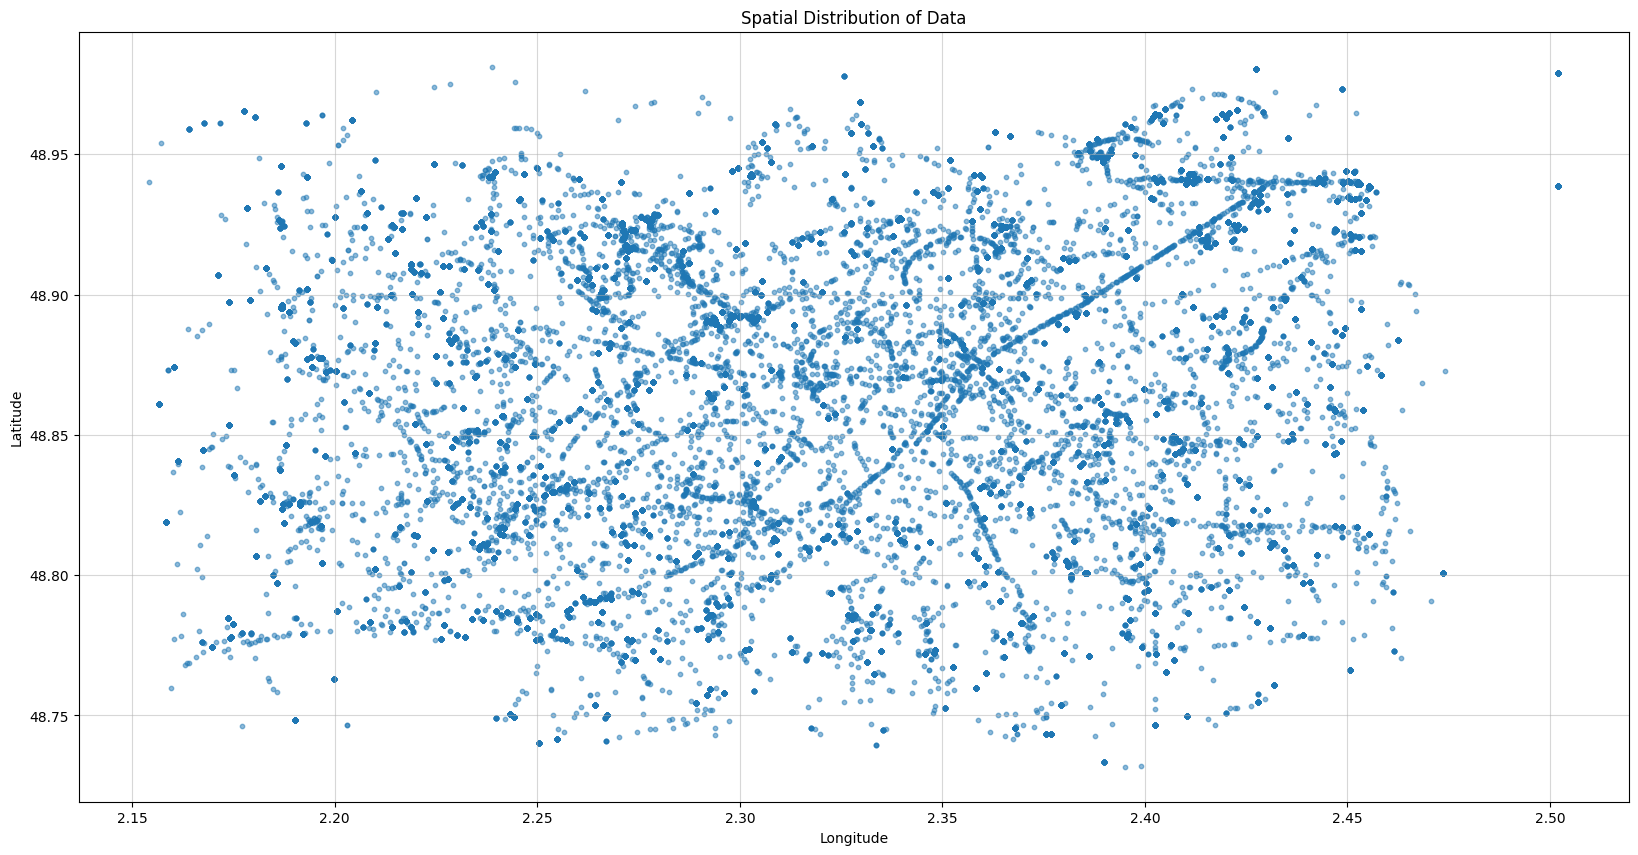

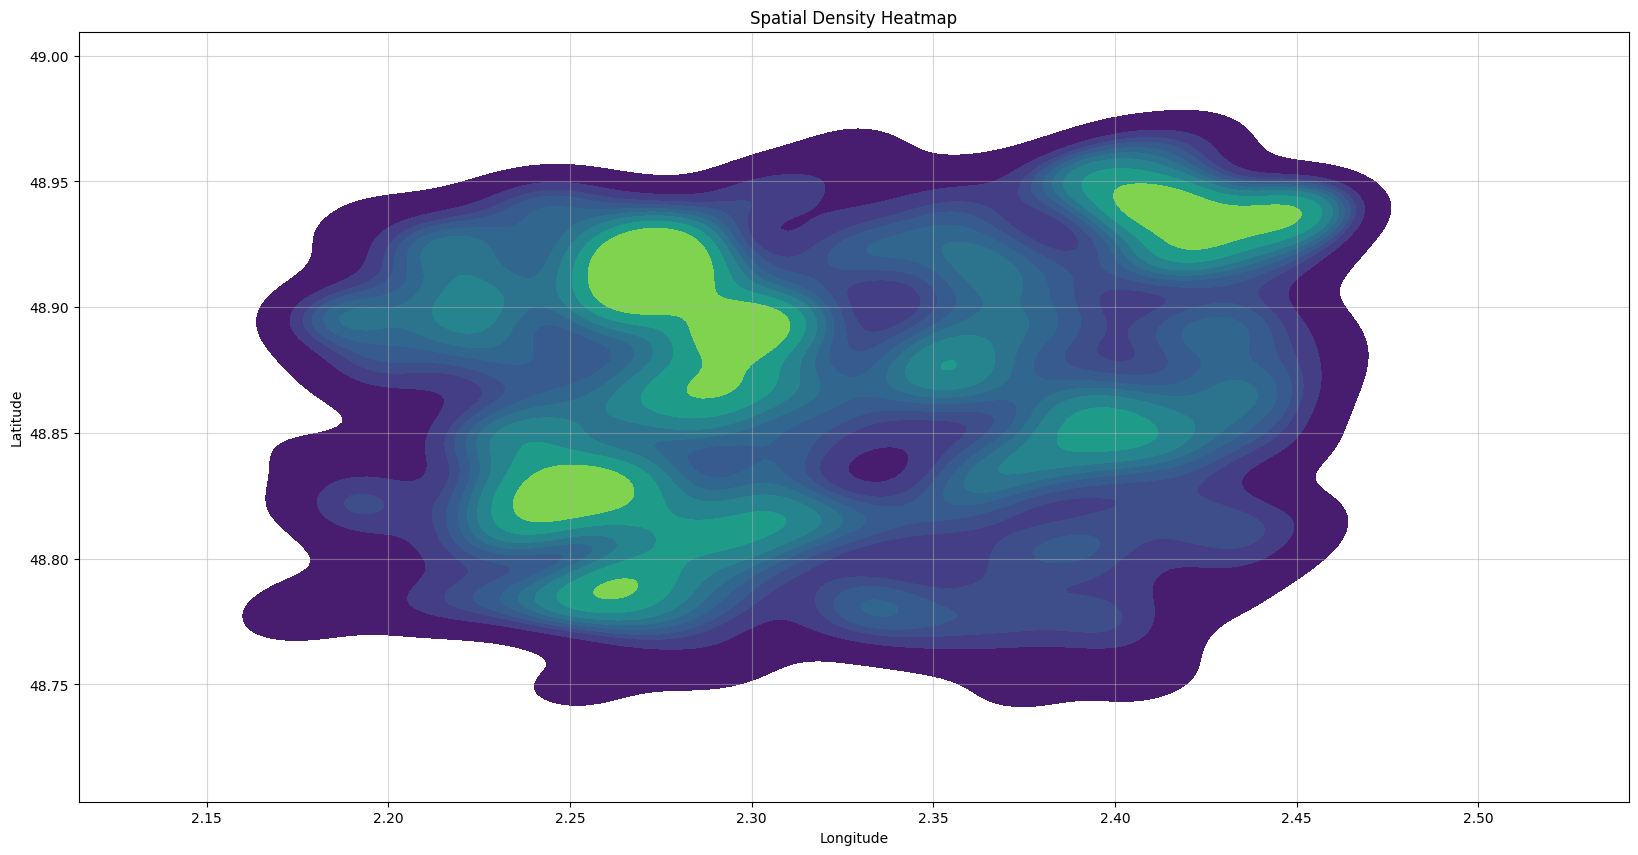

In [41]:
anonymized_data.columns = ['id', 'date', 'latitude', 'longitude']
spatial_analysis(anonymized_data)

In [42]:
anonymized_data.to_csv(DESTINATION_FILE, sep='\t', index=False, header=False)

In [43]:
import sys
import os

sys.path.append(os.path.abspath('../utils'))
from zip import zip_csv_file

zip_csv_file(DESTINATION_FILE, DESTINATION_FILE.replace('.csv', '.zip'))

Successfully created ../ano_data/anonymized_bigger_survey_data.zip


True